In [3]:
# High level implementation of naive bayes

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from scipy.stats import norm
import time
import seaborn as sns
from joblib import Parallel, delayed


class OptimizedGaussianNB:
    """
    An optimized implementation of Gaussian Naive Bayes classifier.
    This class provides vectorized computations and parallel processing for improved performance.
    """

    def __init__(self, var_smoothing=1e-9, n_jobs=-1):
        """
        Initialize the OptimizedGaussianNB classifier.

        Parameters:
        ----------
        var_smoothing : float, default=1e-9
            Portion of the largest variance of all features that is added to variances for calculation stability.
        n_jobs : int, default=-1
            Number of jobs to run in parallel. -1 means using all processors.
        """
        self.var_smoothing = var_smoothing
        self.n_jobs = n_jobs
        self.classes_ = None
        self.class_prior_ = None
        self.class_count_ = None
        self.theta_ = None
        self.sigma_ = None
        self.epsilon_ = None

    def fit(self, X, y):
        """
        Fit Gaussian Naive Bayes according to X, y.

        Parameters:
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vectors.
        y : array-like of shape (n_samples,)
            Target values.

        Returns:
        -------
        self : object
        """
        # Convert inputs to numpy arrays
        X = np.asarray(X)
        y = np.asarray(y)

        # Validate input dimensions
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y have incompatible shapes")

        # Get unique classes and their counts
        self.classes_, self.class_count_ = np.unique(y, return_counts=True)
        n_classes = len(self.classes_)
        n_features = X.shape[1]

        # Compute class prior probabilities
        self.class_prior_ = self.class_count_ / X.shape[0]

        # Initialize parameters
        self.theta_ = np.zeros((n_classes, n_features))
        self.sigma_ = np.zeros((n_classes, n_features))

        # Vectorized computation of mean and variance for each class
        for i, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.theta_[i, :] = np.mean(X_c, axis=0)
            self.sigma_[i, :] = np.var(X_c, axis=0)

        # Apply smoothing to variances
        self.epsilon_ = self.var_smoothing * np.var(X, axis=0).max()
        self.sigma_ += self.epsilon_

        return self

    def _joint_log_likelihood(self, X):
        """
        Calculate the joint log likelihood for each class.

        Parameters:
        ----------
        X : array-like of shape (n_samples, n_features)
            Input vectors.

        Returns:
        -------
        joint_log_likelihood : array of shape (n_samples, n_classes)
            Joint log likelihood for each sample and each class.
        """
        joint_log_likelihood = []

        for i in range(len(self.classes_)):
            jointi = np.log(self.class_prior_[i])

            # Vectorized normal distribution PDF calculation
            n_ij = -0.5 * np.sum(np.log(2 * np.pi * self.sigma_[i, :]))
            n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
                                  self.sigma_[i, :], axis=1)
            joint_log_likelihood.append(jointi + n_ij)

        joint_log_likelihood = np.array(joint_log_likelihood).T
        return joint_log_likelihood

    def predict_proba(self, X):
        """
        Return probability estimates for the test vector X.

        Parameters:
        ----------
        X : array-like of shape (n_samples, n_features)
            Input vectors.

        Returns:
        -------
        C : array-like of shape (n_samples, n_classes)
            Probability estimates for each class.
        """
        X = np.asarray(X)
        joint_log_likelihood = self._joint_log_likelihood(X)

        # Normalize log probabilities to get probabilities
        log_prob_x = logsumexp(joint_log_likelihood, axis=1)
        log_prob = joint_log_likelihood - log_prob_x[:, np.newaxis]
        return np.exp(log_prob)

    def predict(self, X):
        """
        Perform classification on an array of test vectors X.

        Parameters:
        ----------
        X : array-like of shape (n_samples, n_features)
            Input vectors.

        Returns:
        -------
        C : array-like of shape (n_samples,)
            Predicted target values for X.
        """
        jll = self._joint_log_likelihood(X)
        return self.classes_[np.argmax(jll, axis=1)]


def logsumexp(arr, axis=0):
    """
    Compute the log of the sum of exponentials of input elements along the specified axis.

    Parameters:
    ----------
    arr : array-like
        Input array.
    axis : int, optional
        Axis along which the logsumexp is performed.

    Returns:
    -------
    logsumexp : ndarray
        The result of the computation.
    """
    arr_max = np.max(arr, axis=axis, keepdims=True)
    return arr_max.reshape(-1) + np.log(np.sum(np.exp(arr - arr_max), axis=axis))

In [4]:
# Naive Bayes Visualizer

class NaiveBayesVisualizer:
    """
    A class to visualize Naive Bayes classification results including:
    - Decision boundaries
    - Feature distributions
    - Confusion matrix
    - Model performance metrics
    """

    def __init__(self, nb_classifier, X_train, X_test, y_train, y_test, feature_names=None, class_names=None):
        """
        Initialize the visualizer with data and classifier.

        Parameters:
        ----------
        nb_classifier : trained Naive Bayes classifier
            The trained classifier to visualize.
        X_train : array-like of shape (n_samples, n_features)
            Training data.
        X_test : array-like of shape (n_samples, n_features)
            Test data.
        y_train : array-like of shape (n_samples,)
            Training labels.
        y_test : array-like of shape (n_samples,)
            Test labels.
        feature_names : list of str, optional
            Names of the features.
        class_names : list of str, optional
            Names of the classes.
        """
        self.classifier = nb_classifier
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        # Default feature and class names if not provided
        if feature_names is None:
            self.feature_names = [f"Feature {i+1}" for i in range(X_train.shape[1])]
        else:
            self.feature_names = feature_names

        if class_names is None:
            self.class_names = [f"Class {i}" for i in range(len(np.unique(y_train)))]
        else:
            self.class_names = class_names

        # Make predictions
        self.y_pred = self.classifier.predict(self.X_test)
        self.accuracy = accuracy_score(self.y_test, self.y_pred)

    def plot_decision_boundary(self, resolution=100, pca_components=2):
        """
        Plot the decision boundary of the classifier.
        If features > 2, PCA is used to reduce dimensions for visualization.

        Parameters:
        ----------
        resolution : int, default=100
            Resolution of the meshgrid.
        pca_components : int, default=2
            Number of PCA components to use for visualization.
        """
        # Apply PCA if dimensions > 2
        if self.X_train.shape[1] > 2:
            pca = PCA(n_components=pca_components)
            X_train_pca = pca.fit_transform(self.X_train)
            X_test_pca = pca.transform(self.X_test)

            # Train a new classifier on the PCA data for visualization purposes
            viz_classifier = GaussianNB()
            viz_classifier.fit(X_train_pca, self.y_train)

            feature_names = [f"PC{i+1}" for i in range(pca_components)]
            explained_variance = pca.explained_variance_ratio_
        else:
            X_train_pca = self.X_train
            X_test_pca = self.X_test
            viz_classifier = self.classifier
            feature_names = self.feature_names[:2]
            explained_variance = [1.0, 1.0]

        # Create a meshgrid
        x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
        y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                             np.linspace(y_min, y_max, resolution))

        # Predict class labels for each point in the meshgrid
        Z = viz_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot the decision boundary
        plt.figure(figsize=(12, 10))
        cmap = ListedColormap(plt.cm.tab10.colors[:len(np.unique(self.y_train))])

        plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
        scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=self.y_test,
                             edgecolor='k', alpha=0.8, cmap=cmap)

        # Highlight misclassified points
        misclassified = self.y_pred != self.y_test
        if np.any(misclassified):
            plt.scatter(X_test_pca[misclassified, 0], X_test_pca[misclassified, 1],
                       edgecolor='red', s=100, facecolors='none', linewidth=2,
                       label='Misclassified')

        # Add legend and labels
        # Original line causing error:
        # legend1 = plt.legend(handles=scatter.legend_elements()[0],
        #                     labels=self.class_names, title="Classes")
        # Modified line to use scatter object directly
        legend1 = plt.legend(*scatter.legend_elements(),
                             labels=self.class_names, title="Classes") # Use *scatter.legend_elements()

        plt.gca().add_artist(legend1)

        if np.any(misclassified):
            # Add the misclassified legend separately
            plt.legend(handles=[plt.gca().get_children()[-1]], loc='upper right')


        plt.title(f'Decision Boundary (Accuracy: {self.accuracy:.2f})', fontsize=15)
        plt.xlabel(f'{feature_names[0]} ({explained_variance[0]:.2%} variance)')
        plt.ylabel(f'{feature_names[1]} ({explained_variance[1]:.2%} variance)')
        plt.tight_layout()
        plt.show()
    def plot_feature_distributions(self, max_features=4):
        """
        Plot the Gaussian distribution of features for each class.

        Parameters:
        ----------
        max_features : int, default=4
            Maximum number of features to plot.
        """
        n_features = min(max_features, self.X_train.shape[1])
        n_classes = len(np.unique(self.y_train))

        plt.figure(figsize=(15, n_features * 3))

        for i in range(n_features):
            plt.subplot(n_features, 1, i + 1)

            for j, c in enumerate(np.unique(self.y_train)):
                # Get data for this class and feature
                X_c = self.X_train[self.y_train == c, i]

                # Plot histogram of the data
                sns.histplot(X_c, kde=True, stat="density", alpha=0.4,
                            label=f"{self.class_names[j]} (Data)", color=plt.cm.tab10(j))

                # Plot the Gaussian distribution used by Naive Bayes
                if hasattr(self.classifier, 'theta_'):
                    # For our custom classifier
                    mean = self.classifier.theta_[j, i]
                    std = np.sqrt(self.classifier.sigma_[j, i])
                elif hasattr(self.classifier, 'theta_'):
                    # For sklearn's GaussianNB
                    mean = self.classifier.theta_[j, i]
                    std = np.sqrt(self.classifier.var_[j, i])
                else:
                    continue

                x = np.linspace(self.X_train[:, i].min(), self.X_train[:, i].max(), 1000)
                y = norm.pdf(x, mean, std)
                plt.plot(x, y, label=f"{self.class_names[j]} (NB Model)",
                        linestyle='--', linewidth=2, color=plt.cm.tab10(j))

            plt.title(f'Feature Distribution: {self.feature_names[i]}', fontsize=13)
            plt.xlabel('Feature Value')
            plt.ylabel('Density')
            plt.legend()
            plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self):
        """Plot the confusion matrix for the classifier."""
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(self.y_test, self.y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)

        plt.title('Confusion Matrix', fontsize=15)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

    def plot_performance_metrics(self):
        """Plot various performance metrics for the classifier."""
        # Get classification report
        report = classification_report(self.y_test, self.y_pred,
                                     target_names=self.class_names,
                                     output_dict=True)

        # Extract metrics
        metrics_df = pd.DataFrame({
            'Precision': [report[c]['precision'] for c in self.class_names],
            'Recall': [report[c]['recall'] for c in self.class_names],
            'F1-Score': [report[c]['f1-score'] for c in self.class_names]
        }, index=self.class_names)

        # Plot metrics
        plt.figure(figsize=(12, 6))
        metrics_df.plot(kind='bar', rot=0, figsize=(12, 6))
        plt.title('Classification Metrics by Class', fontsize=15)
        plt.ylabel('Score')
        plt.ylim(0, 1.05)
        plt.grid(axis='y', alpha=0.3)

        # Add overall accuracy
        plt.axhline(y=self.accuracy, color='r', linestyle='--',
                   label=f'Overall Accuracy: {self.accuracy:.2f}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_probability_calibration(self):
        """Plot probability calibration curves for each class."""
        if not hasattr(self.classifier, 'predict_proba'):
            print("Classifier does not support probability prediction.")
            return

        # Get predicted probabilities
        y_probs = self.classifier.predict_proba(self.X_test)

        plt.figure(figsize=(12, 8))

        # For each class, create a reliability curve
        for i, class_name in enumerate(self.class_names):
            # Convert to binary classification problem (one-vs-rest)
            y_true_binary = (self.y_test == i).astype(int)
            y_prob_binary = y_probs[:, i]

            # Create 10 bins for probabilities
            bins = np.linspace(0, 1, 11)
            bin_indices = np.digitize(y_prob_binary, bins) - 1
            bin_indices = np.clip(bin_indices, 0, len(bins) - 2)

            bin_sums = np.bincount(bin_indices, weights=y_true_binary, minlength=len(bins) - 1)
            bin_counts = np.bincount(bin_indices, minlength=len(bins) - 1)
            nonzero = bin_counts > 0

            # Calculate fraction of positive samples in each bin
            bin_fractions = np.zeros(len(bins) - 1)
            bin_fractions[nonzero] = bin_sums[nonzero] / bin_counts[nonzero]

            # Calculate bin centers
            bin_centers = (bins[:-1] + bins[1:]) / 2

            plt.plot(bin_centers, bin_fractions, marker='o', linestyle='-',
                    label=f'{class_name}')

        # Plot ideal calibration line
        plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

        plt.title('Probability Calibration Curve', fontsize=15)
        plt.xlabel('Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.legend(loc='best')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    def visualize_all(self):
        """Generate all visualizations."""
        print("Visualizing Decision Boundary...")
        self.plot_decision_boundary()

        print("Visualizing Feature Distributions...")
        self.plot_feature_distributions()

        print("Visualizing Confusion Matrix...")
        self.plot_confusion_matrix()

        print("Visualizing Performance Metrics...")
        self.plot_performance_metrics()

        print("Visualizing Probability Calibration...")
        self.plot_probability_calibration()

In [5]:
# benchmark naive bayes

def benchmark_naive_bayes(X, y, n_iterations=5):
    """
    Benchmark different Naive Bayes implementations.

    Parameters:
    ----------
    X : array-like of shape (n_samples, n_features)
        Input data.
    y : array-like of shape (n_samples,)
        Target values.
    n_iterations : int, default=5
        Number of iterations for timing.

    Returns:
    -------
    results : dict
        Benchmark results.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize classifiers
    classifiers = {
        'Sklearn GaussianNB': GaussianNB(),
        'Optimized GaussianNB': OptimizedGaussianNB()
    }

    results = {}

    for name, clf in classifiers.items():
        # Measure training time
        train_times = []
        for _ in range(n_iterations):
            start_time = time.time()
            clf.fit(X_train, y_train)
            train_times.append(time.time() - start_time)

        # Measure prediction time
        pred_times = []
        for _ in range(n_iterations):
            start_time = time.time()
            y_pred = clf.predict(X_test)
            pred_times.append(time.time() - start_time)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        results[name] = {
            'Avg. Training Time (s)': np.mean(train_times),
            'Avg. Prediction Time (s)': np.mean(pred_times),
            'Accuracy': accuracy
        }

    return results

In [6]:
# Plot Benchmark

def plot_benchmark_results(results):
    """
    Plot benchmark results.

    Parameters:
    ----------
    results : dict
        Benchmark results.
    """
    # Prepare data for plotting
    names = list(results.keys())
    train_times = [results[name]['Avg. Training Time (s)'] for name in names]
    pred_times = [results[name]['Avg. Prediction Time (s)'] for name in names]
    accuracies = [results[name]['Accuracy'] for name in names]

    # Create plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    x = np.arange(len(names))
    width = 0.35

    # Plot times on left axis
    rects1 = ax1.bar(x - width/2, train_times, width, label='Training Time')
    rects2 = ax1.bar(x + width/2, pred_times, width, label='Prediction Time')

    ax1.set_ylabel('Time (s)')
    ax1.set_title('Naive Bayes Implementations Benchmark')
    ax1.set_xticks(x)
    ax1.set_xticklabels(names)
    ax1.legend(loc='upper left')

    # Plot accuracy on right axis
    ax2 = ax1.twinx()
    ax2.plot(x, accuracies, 'ro-', label='Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper right')

    # Add values on top of bars
    def autolabel(rects, ax):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

    autolabel(rects1, ax1)
    autolabel(rects2, ax1)

    fig.tight_layout()
    plt.show()

In [7]:
# Demo usage function, Synthetic data
def run_naive_bayes_demo(n_samples=1000, n_features=20, n_classes=3, random_state=42):
    """
    Demo the Naive Bayes implementation with synthetic data.

    Parameters:
    ----------
    n_samples : int, default=1000
        Number of samples to generate.
    n_features : int, default=20
        Number of features to generate.
    n_classes : int, default=3
        Number of classes.
    random_state : int, default=42
        Random state for reproducibility.
    """
    print(f"Generating synthetic dataset with {n_samples} samples, {n_features} features, and {n_classes} classes...")

    # Generate synthetic data
    X, y = make_classification(n_samples=n_samples, n_features=n_features,
                              n_informative=int(n_features * 0.8),
                              n_redundant=int(n_features * 0.1),
                              n_classes=n_classes, random_state=random_state)

    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    print("Fitting Optimized Naive Bayes classifier...")
    nb = OptimizedGaussianNB()
    nb.fit(X_train, y_train)

    # Create feature and class names
    feature_names = [f"Feature {i+1}" for i in range(n_features)]
    class_names = [f"Class {i}" for i in range(n_classes)]

    print("Creating visualizer...")
    visualizer = NaiveBayesVisualizer(nb, X_train, X_test, y_train, y_test,
                                     feature_names=feature_names,
                                     class_names=class_names)

    print("Generating visualizations...")
    visualizer.visualize_all()

    print("Running benchmark comparison...")
    benchmark_results = benchmark_naive_bayes(X, y)

    # Print benchmark results
    print("\nBenchmark Results:")
    for name, metrics in benchmark_results.items():
        print(f"\n{name}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.6f}")

    plot_benchmark_results(benchmark_results)


Generating synthetic dataset with 2000 samples, 10 features, and 3 classes...
Fitting Optimized Naive Bayes classifier...
Creating visualizer...
Generating visualizations...
Visualizing Decision Boundary...


<ipython-input-4-8572fcc537b4>:115: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  legend1 = plt.legend(*scatter.legend_elements(),


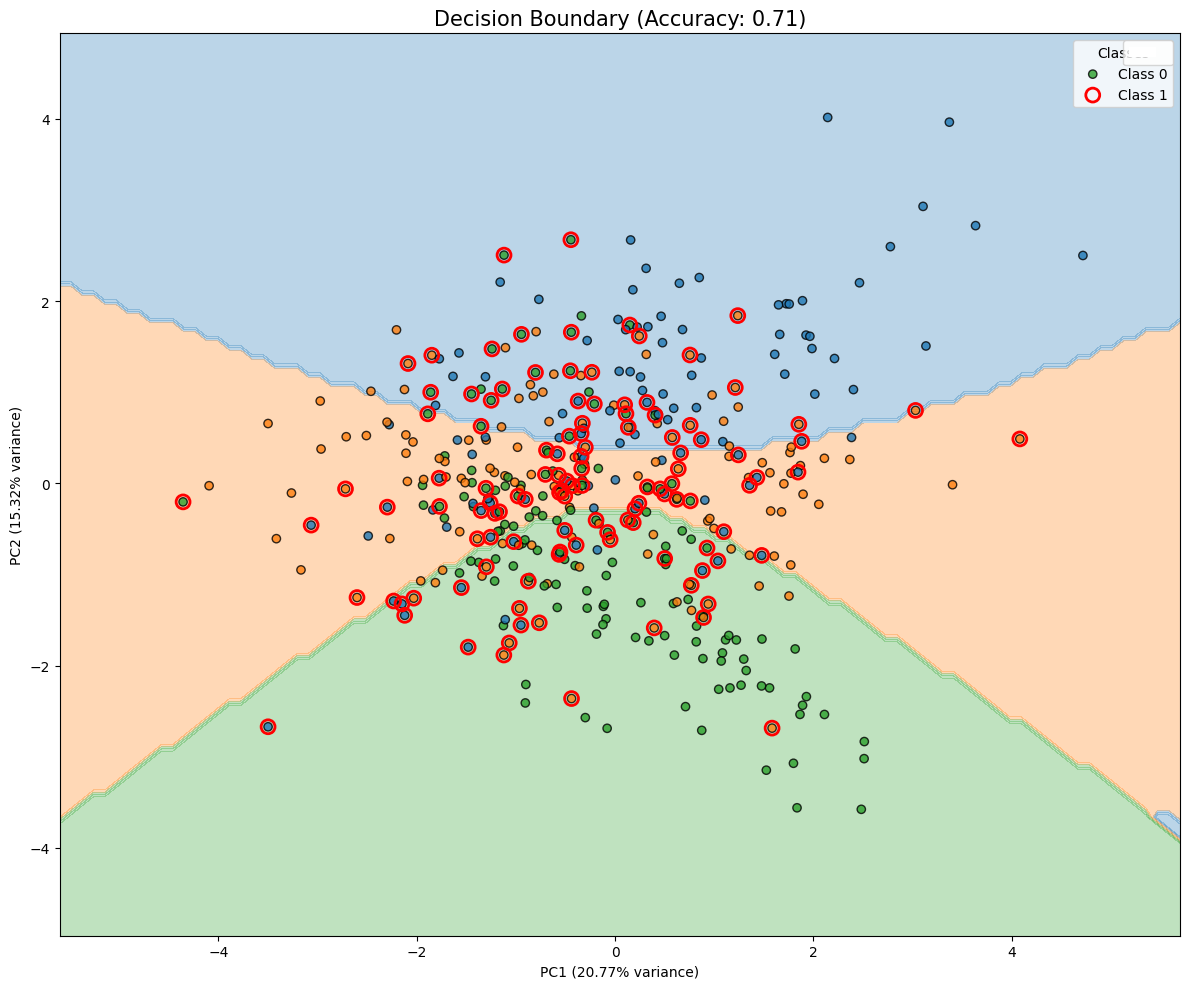

Visualizing Feature Distributions...


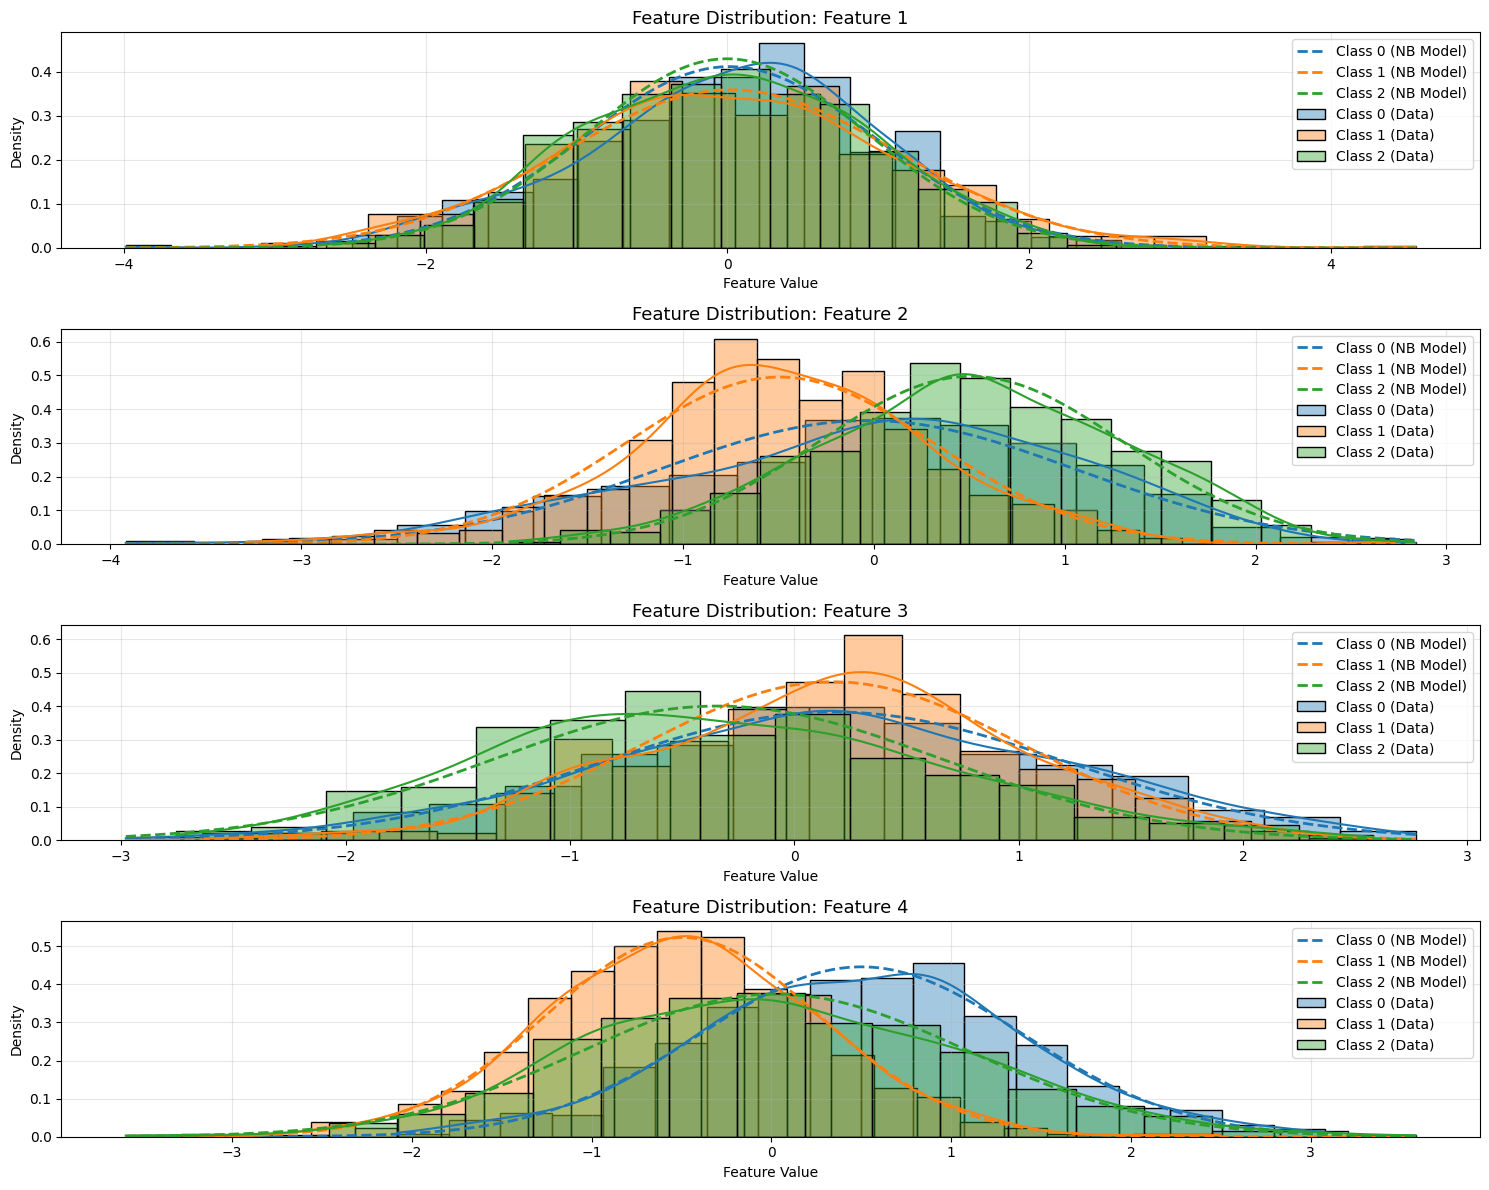

Visualizing Confusion Matrix...


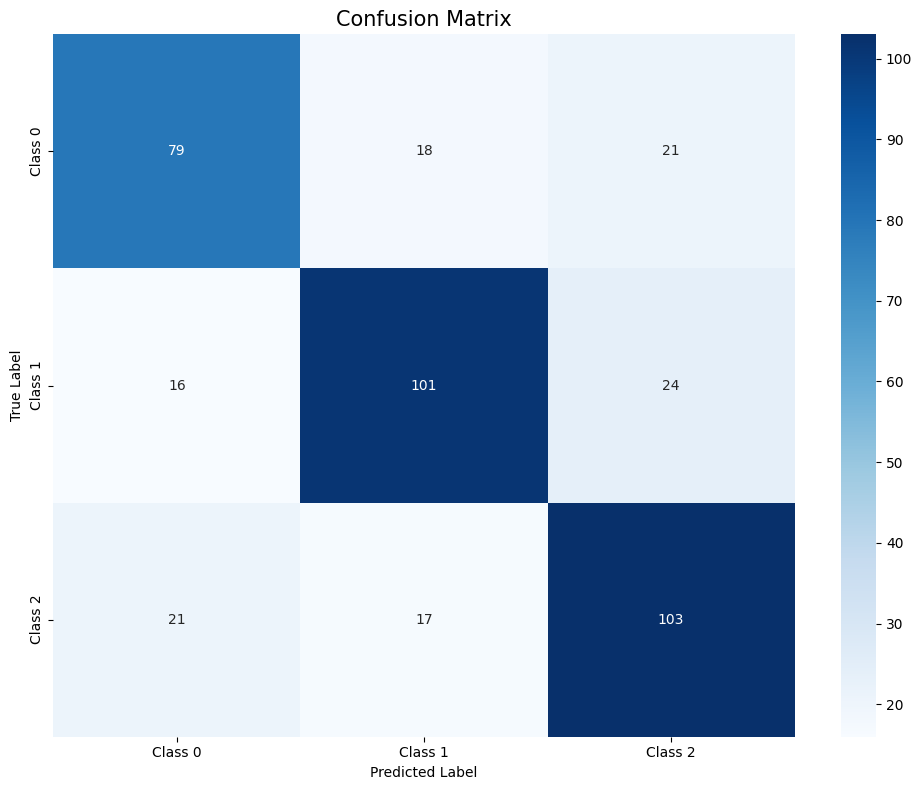

Visualizing Performance Metrics...


<Figure size 1200x600 with 0 Axes>

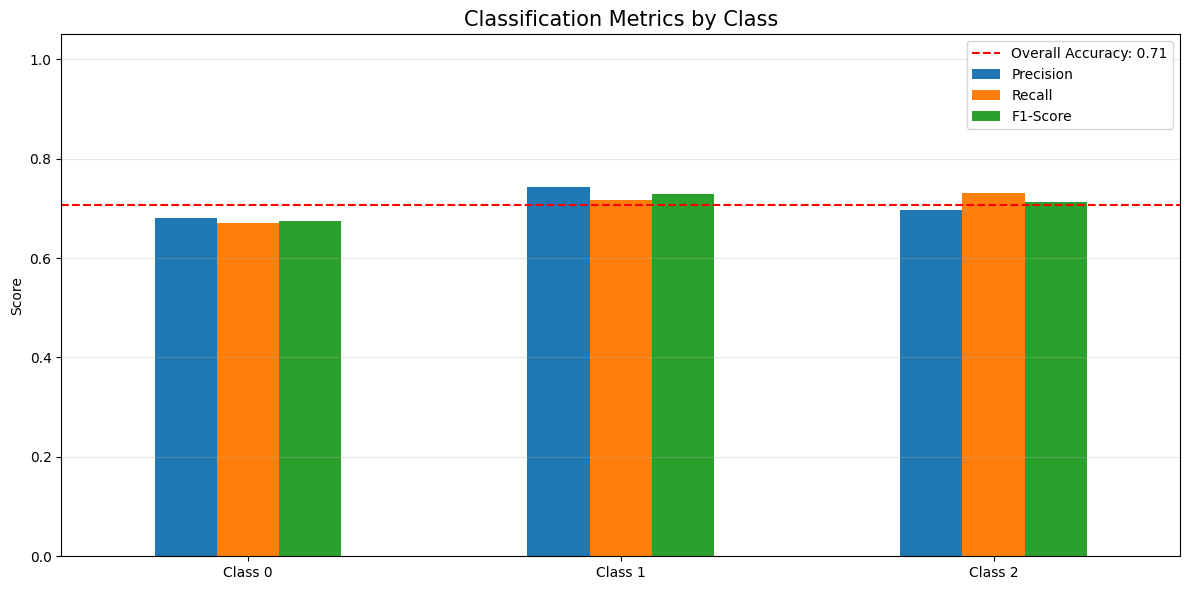

Visualizing Probability Calibration...


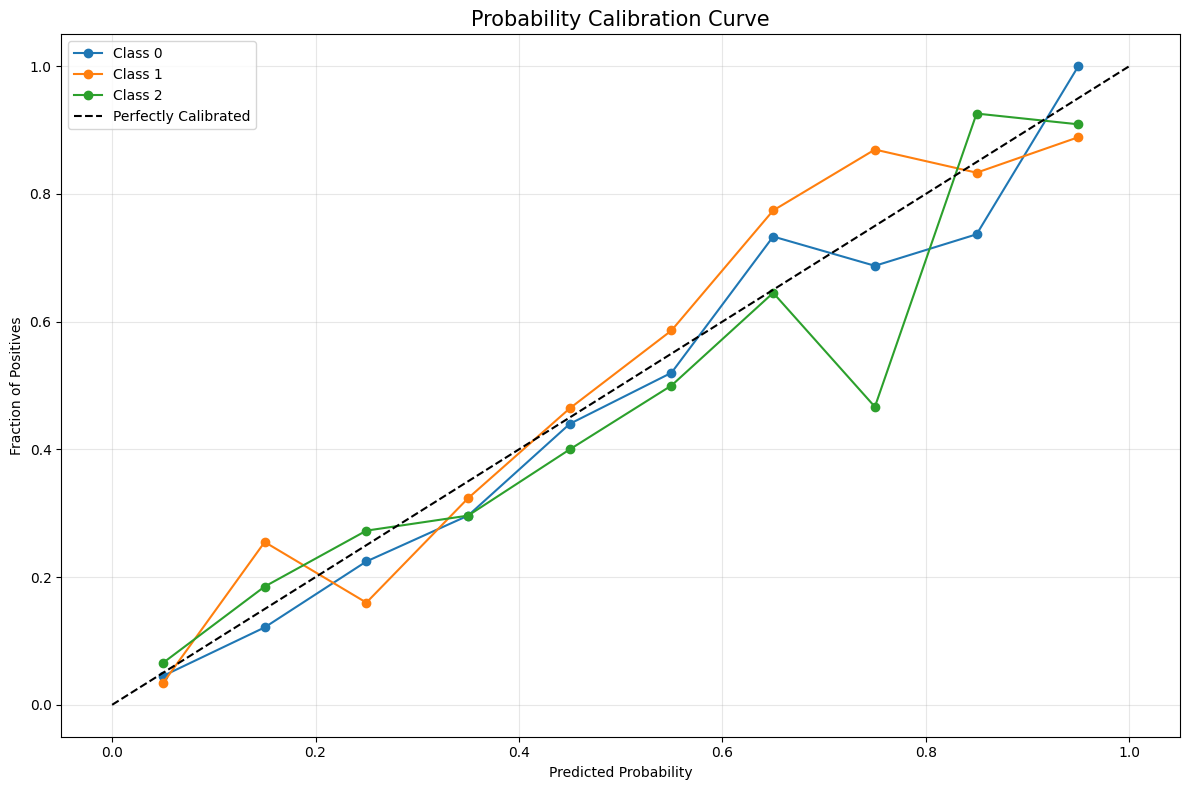

Running benchmark comparison...

Benchmark Results:

Sklearn GaussianNB:
  Avg. Training Time (s): 0.002266
  Avg. Prediction Time (s): 0.000452
  Accuracy: 0.707500

Optimized GaussianNB:
  Avg. Training Time (s): 0.000910
  Avg. Prediction Time (s): 0.000244
  Accuracy: 0.707500


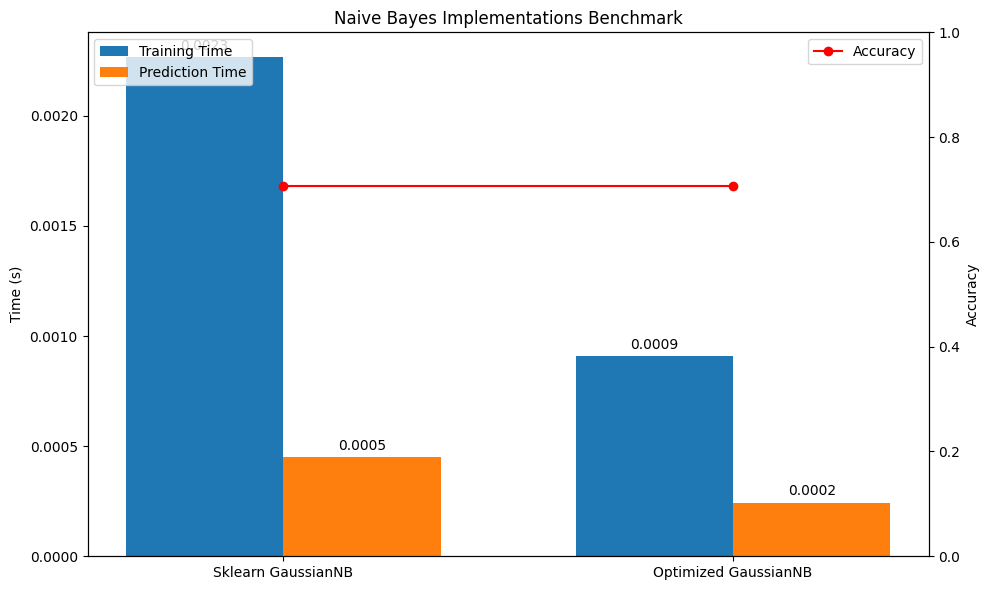

In [8]:
if __name__ == "__main__":
    # Import additional libraries needed for the main function
    import pandas as pd

    # Run the demo
    run_naive_bayes_demo(n_samples=2000, n_features=10, n_classes=3)

In [9]:
# Demo usage function with iris dataset

def run_naive_bayes_demo(dataset='iris', random_state=42):
    """
    Demo the Naive Bayes implementation with real-world datasets.

    Parameters:
    ----------
    dataset : str, default='iris'
        Dataset to use. Options: 'iris', 'weather'
    random_state : int, default=42
        Random state for reproducibility.
    """
    if dataset.lower() == 'iris':
        print("Loading Iris dataset...")
        from sklearn.datasets import load_iris
        data = load_iris()
        X = data.data
        y = data.target
        feature_names = data.feature_names
        class_names = data.target_names
        print(f"Loaded Iris dataset with {X.shape[0]} samples, {X.shape[1]} features, and {len(class_names)} classes")

    elif dataset.lower() == 'weather':
        print("Loading Weather dataset...")
        # A simple weather dataset for demonstration
        # You can replace this with a real weather dataset if available
        weather_data = {
            'outlook': ['sunny', 'sunny', 'overcast', 'rainy', 'rainy', 'rainy', 'overcast',
                       'sunny', 'sunny', 'rainy', 'sunny', 'overcast', 'overcast', 'rainy'],
            'temperature': [85, 80, 83, 70, 68, 65, 64, 72, 69, 75, 75, 72, 81, 71],
            'humidity': [85, 90, 78, 96, 80, 70, 65, 95, 70, 80, 70, 90, 75, 80],
            'windy': [False, True, False, False, False, True, True, False, False, False, True, True, False, True],
            'play': ['no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no']
        }

        # Convert categorical variables to numerical
        from sklearn.preprocessing import LabelEncoder
        import pandas as pd

        df = pd.DataFrame(weather_data)

        # Encode categorical features
        le_outlook = LabelEncoder()
        df['outlook_encoded'] = le_outlook.fit_transform(df['outlook'])

        le_windy = LabelEncoder()
        df['windy_encoded'] = le_windy.fit_transform(df['windy'])

        # Encode target
        le_play = LabelEncoder()
        y = le_play.fit_transform(df['play'])

        # Select features
        X = df[['temperature', 'humidity', 'outlook_encoded', 'windy_encoded']].values

        feature_names = ['Temperature', 'Humidity', 'Outlook', 'Windy']
        class_names = le_play.classes_
        print(f"Loaded Weather dataset with {X.shape[0]} samples, {X.shape[1]} features, and {len(class_names)} classes")

    else:
        raise ValueError(f"Unknown dataset: {dataset}. Choose 'iris' or 'weather'.")

    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    print("Fitting Optimized Naive Bayes classifier...")
    nb = OptimizedGaussianNB()
    nb.fit(X_train, y_train)

    print("Creating visualizer...")
    visualizer = NaiveBayesVisualizer(nb, X_train, X_test, y_train, y_test,
                                     feature_names=feature_names,
                                     class_names=class_names)

    print("Generating visualizations...")
    visualizer.visualize_all()

    print("Running benchmark comparison...")
    benchmark_results = benchmark_naive_bayes(X, y)

    # Print benchmark results
    print("\nBenchmark Results:")
    for name, metrics in benchmark_results.items():
        print(f"\n{name}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.6f}")

    plot_benchmark_results(benchmark_results)

Loading Iris dataset...
Loaded Iris dataset with 150 samples, 4 features, and 3 classes
Fitting Optimized Naive Bayes classifier...
Creating visualizer...
Generating visualizations...
Visualizing Decision Boundary...


<ipython-input-4-8572fcc537b4>:115: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  legend1 = plt.legend(*scatter.legend_elements(),


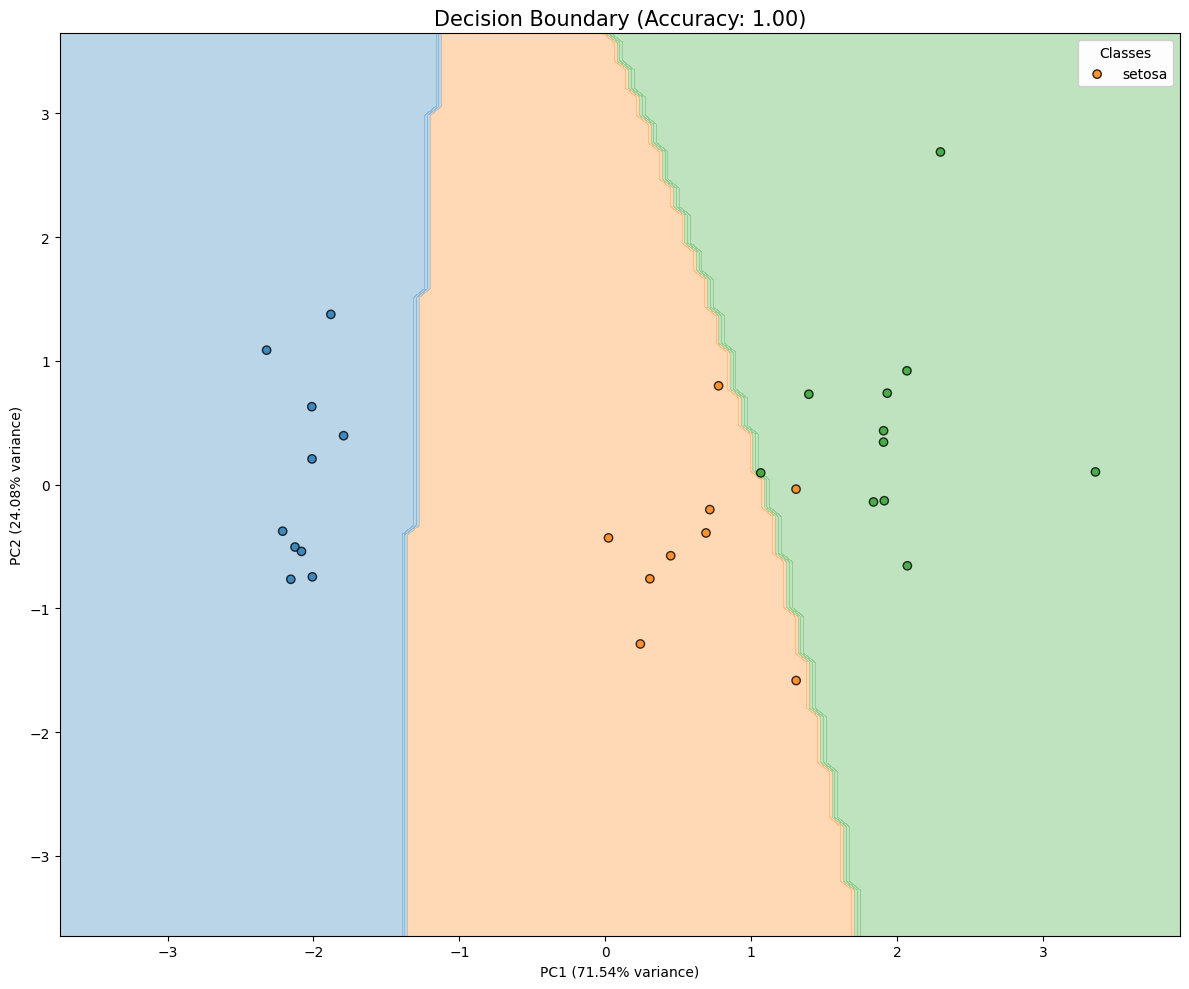

Visualizing Feature Distributions...


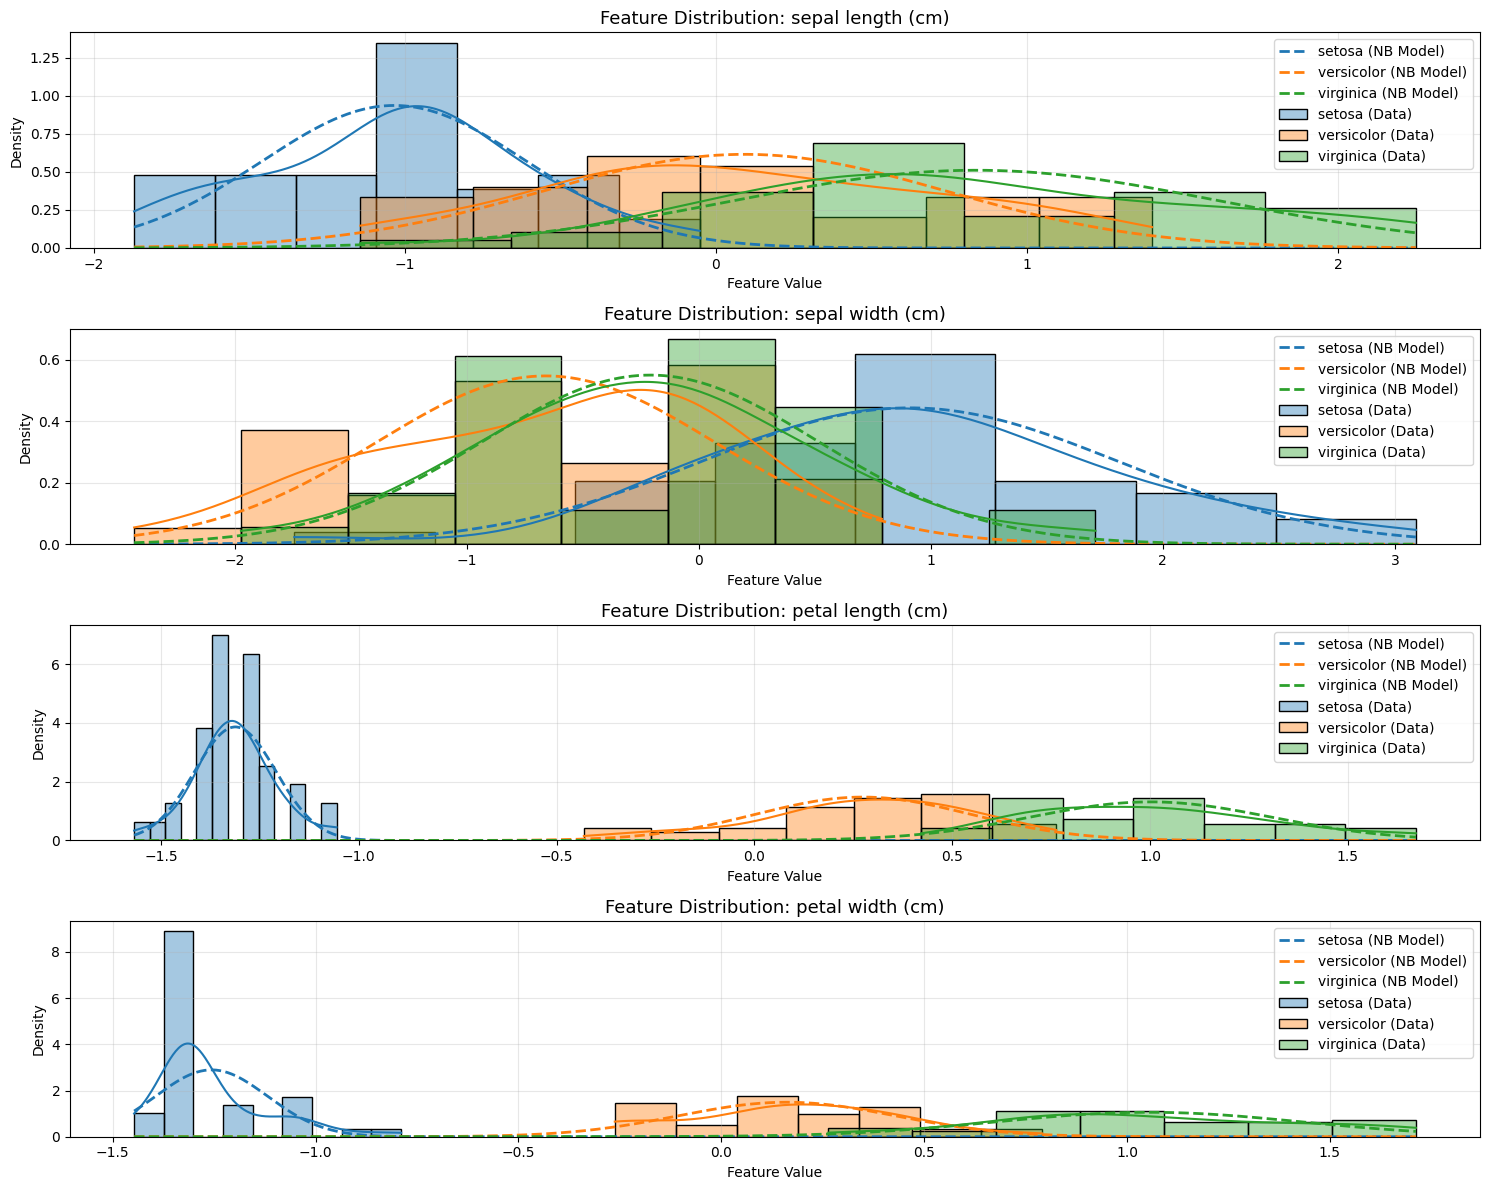

Visualizing Confusion Matrix...


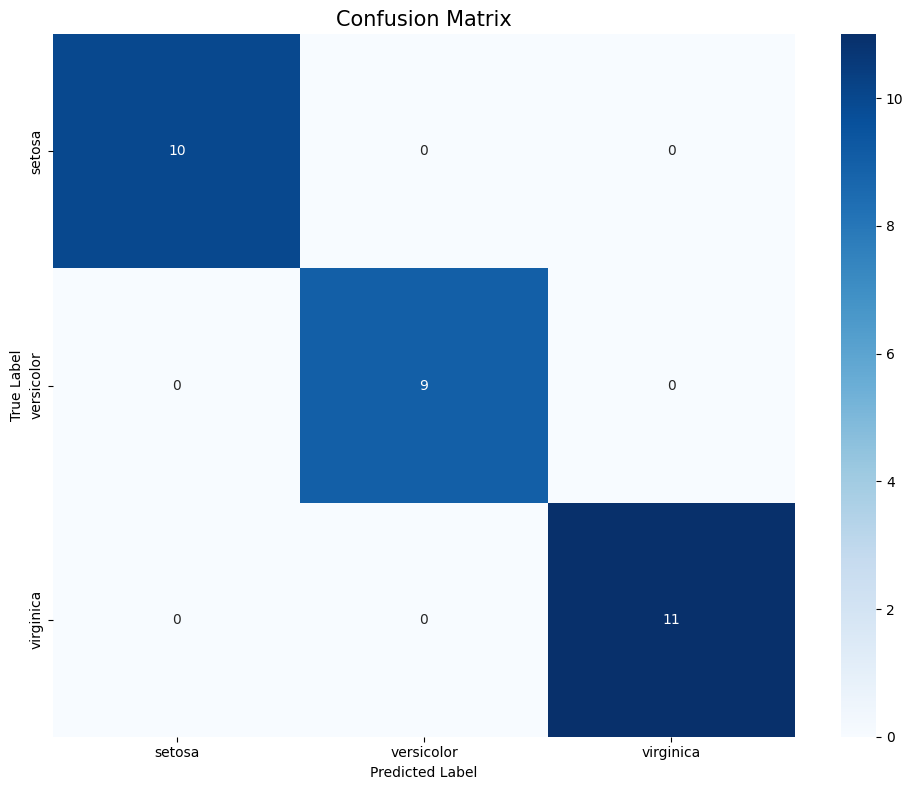

Visualizing Performance Metrics...


<Figure size 1200x600 with 0 Axes>

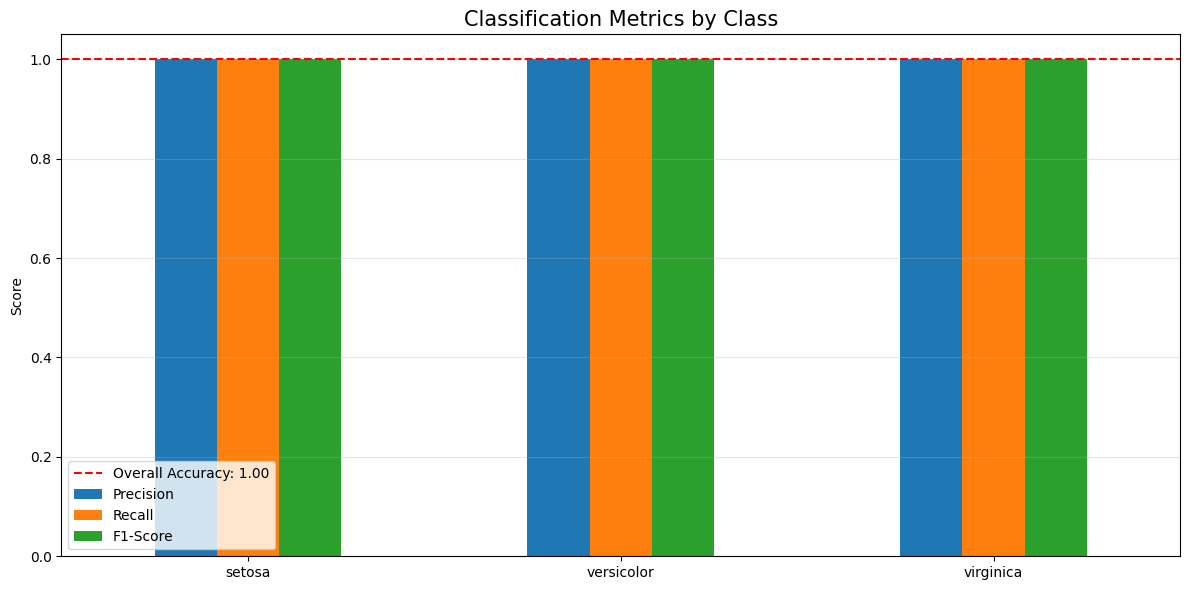

Visualizing Probability Calibration...


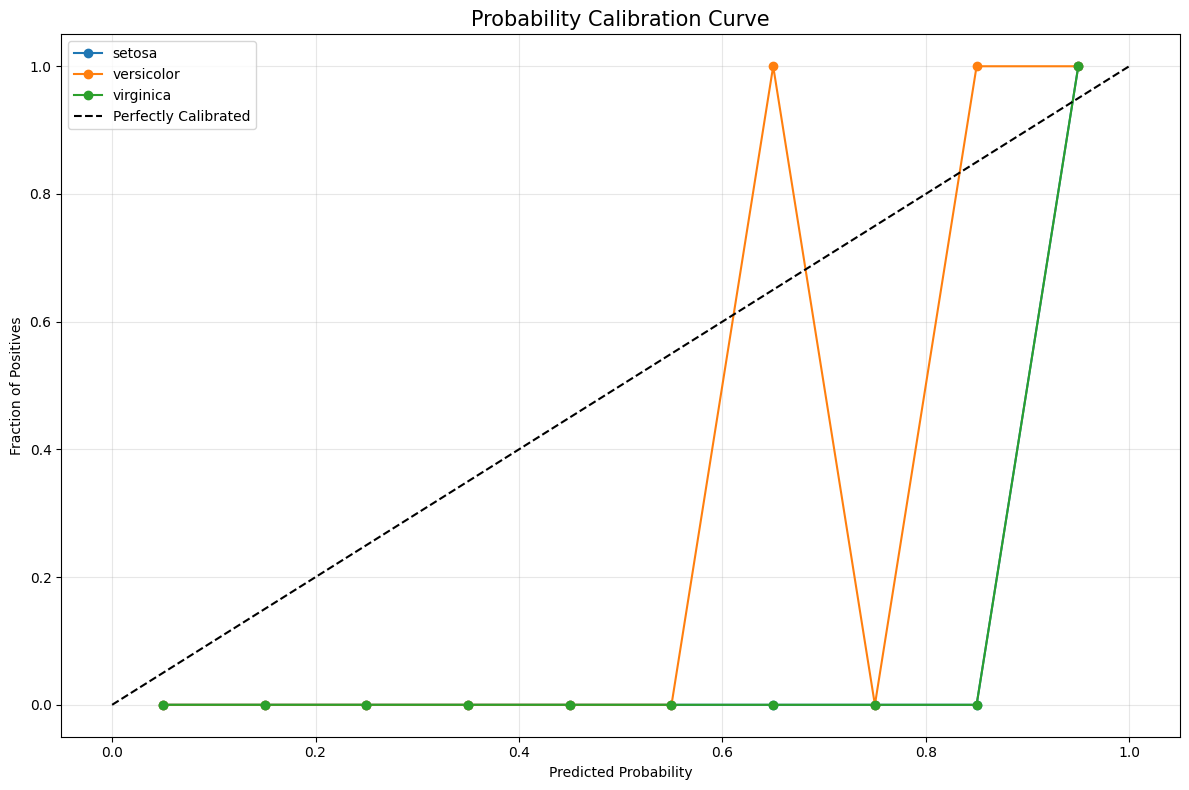

Running benchmark comparison...

Benchmark Results:

Sklearn GaussianNB:
  Avg. Training Time (s): 0.001467
  Avg. Prediction Time (s): 0.000312
  Accuracy: 1.000000

Optimized GaussianNB:
  Avg. Training Time (s): 0.000340
  Avg. Prediction Time (s): 0.000174
  Accuracy: 1.000000


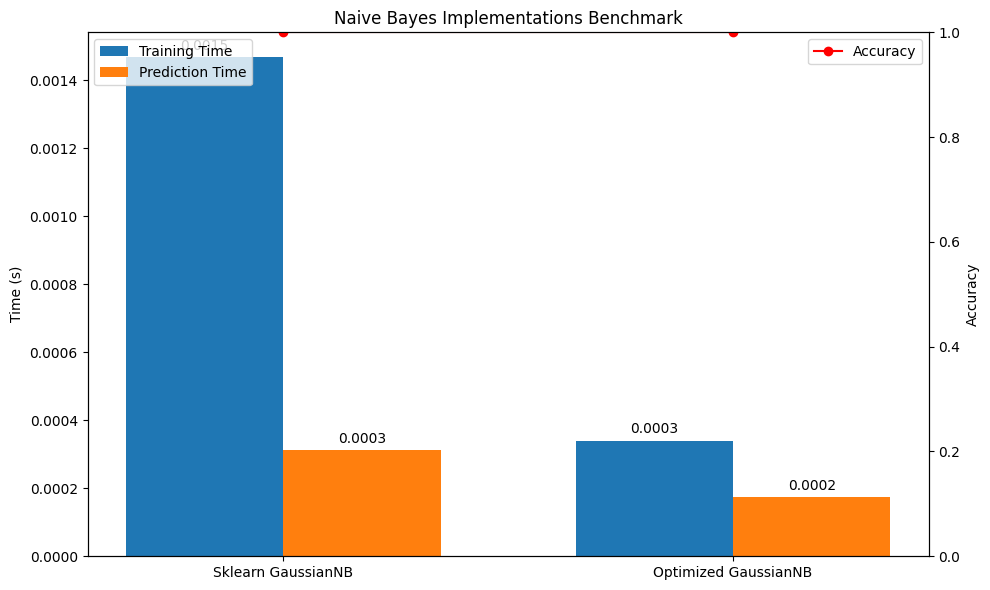

In [10]:
if __name__ == "__main__":
    # Import additional libraries needed for the main function
    import pandas as pd

    # Run the demo with Iris dataset
    run_naive_bayes_demo(dataset='iris')

    # Uncomment to run with weather dataset
    # run_naive_bayes_demo(dataset='weather')